Cluster 1:
- Brokerka danych osobowych
- Analityczka biznesowa
- Analityczka cyber-miasta
- Inżynierka systemów i sieci komputerowych
- Serwisantka sprzętu komputerowego
- Konstruktorka urządzeń transportu osobistego
- Programistka systemów sztucznej inteligencji 
- Bioinformatyczka
- Specjalistka do spraw kontrolingu
- Olfaktoniczka 
- Analityczka systemów teleinformatycznych
- Specjalistka kryptowalut
- Administratorka bezpieczeństwa informacji (inspektorka ochrony danych)
- Specjalistka inżynierii medycznej
- Inżynierka systemów wirtualnej rzeczywistości 
- Projektantka hybrydowej rzeczywistości (MR Journey Designer)
- Inżynierka DevOps
- Analityczka sportowa
- Specjalistka druku i modelowania 3D 
- Dealerka aktywów finansowych
- Projektantka aplikacji multimedialnych, animacji i gier komputerowych
- Etyczna hakerka
- Specjalistka do spraw zarządzania ryzykiem
- Specjalistka obsługi bankomatów
- Inżynierka telemedycyny
- Programistka aplikacji mobilnych
- Aktuariuszka
- Inżynierka b

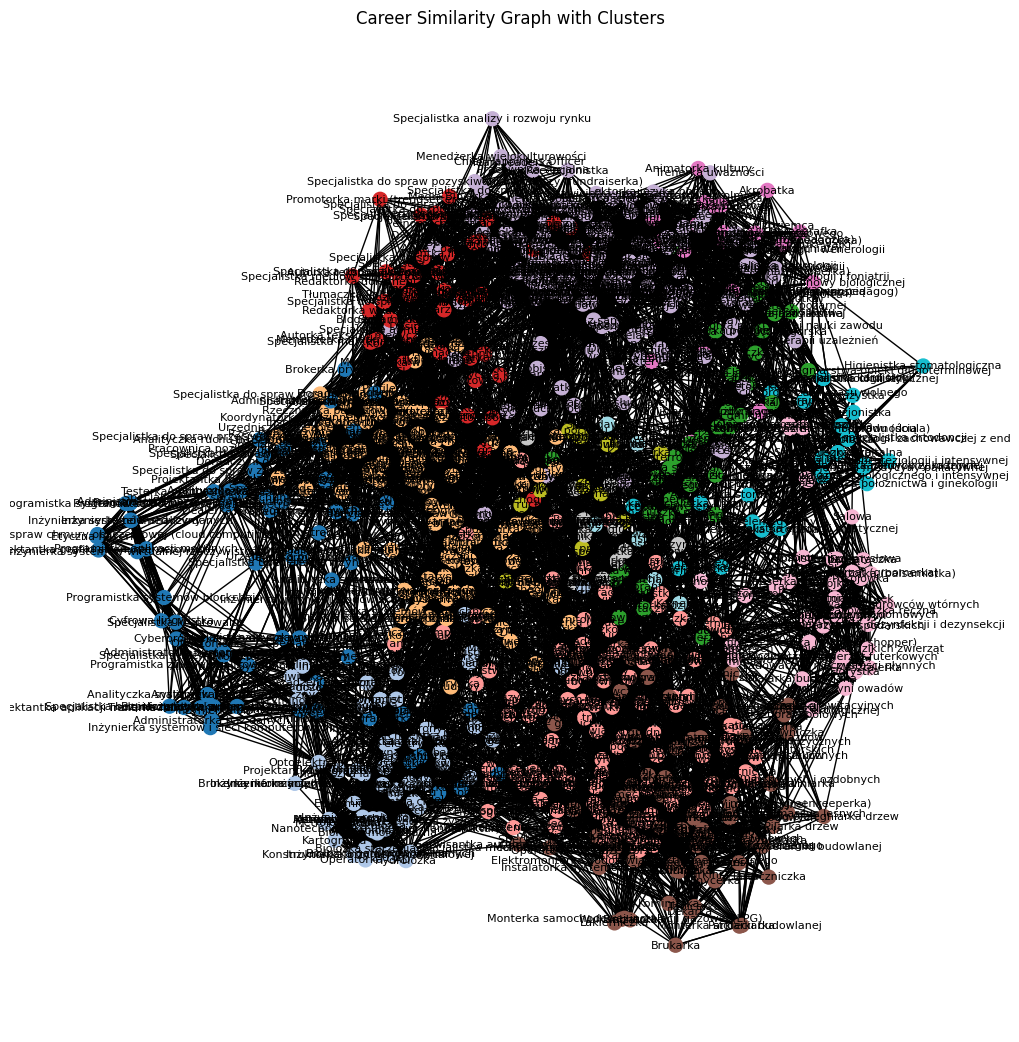

In [118]:
import pandas as pd
import itertools
import networkx as nx
import matplotlib.pyplot as plt
import community  # This library provides community detection algorithms

# Load your dataset into a DataFrame
data = df

# Create a dictionary to store career names and their associated split careers
career_dict = {}

# Iterate through rows and populate the dictionary
for _, row in data.iterrows():
    career_name = row['fullName']
    split_careers = set(row['simillarOccupations'].split(';'))
    
    # Store career names and their split careers in the dictionary
    career_dict[career_name] = split_careers

# Create an empty graph
G = nx.Graph()

# Calculate Jaccard similarity for each pair of careers and add edges to the graph
for pair in itertools.combinations(career_dict.keys(), 2):
    career1, career2 = pair
    
    # Calculate Jaccard similarity (you can use any similarity measure here)
    intersection = len(career_dict[career1] & career_dict[career2])
    union = len(career_dict[career1] | career_dict[career2])
    
    # Define a threshold and add an edge if similarity exceeds the threshold
    threshold = 0
    similarity_score = intersection / union
    if similarity_score > threshold:
        G.add_edge(career1, career2)

# Perform Louvain community detection
partition = nx.community.label_propagation.label_propagation_communities(G)

# Create a mapping of careers to clusters
career_to_cluster = {}
for i, cluster in enumerate(partition):
    for career in cluster:
        career_to_cluster[career] = i

# Print the clusters
for cluster_id, cluster in enumerate(partition):
    print(f"Cluster {cluster_id + 1}:")
    for career in cluster:
        print(f"- {career}")
    print()

# Visualize the graph with colors representing clusters
pos = nx.spring_layout(G)  # You can try different layout algorithms
plt.figure(figsize=(10, 10))  # Set the figure size

# Assign colors to nodes based on clusters
node_colors = [career_to_cluster[career] for career in G.nodes()]

nx.draw(G, pos, with_labels=True, node_size=100, font_size=8, node_color=node_colors, cmap=plt.cm.tab20)
plt.title('Career Similarity Graph with Clusters')
plt.show()  # Display the plot


In [ ]:
# nltk.download('punkt')
# nltk.download('wordnet')
nltk.download('stopwords')

In [9]:
import os
import json

import spacy
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pandas as pd
import random

In [24]:
def compare_context(text1, text2):

    def preprocess_and_vectorize(text):
        doc = nlp(text)
        tokens = [token.text for token in doc if not token.is_stop and not token.is_punct]
        clean_text = ' '.join(tokens)
        vec = nlp(clean_text).vector
        return vec

    nlp = spacy.load("pl_core_news_md")

    vec1 = preprocess_and_vectorize(text1)
    vec2 = preprocess_and_vectorize(text2)

    similarity = cosine_similarity([vec1], [vec2])[0][0]

    return similarity

In [6]:
def load_csv():
    csv_path = os.path.join(os.getcwd(), '..', 'packages/scrapper/DATA/')
    csv_filename = 'occupations.csv'
    path_to_csv = os.path.join(csv_path, csv_filename)

    df = pd.read_csv(path_to_csv)

    return df

In [14]:
def data_preparation(df):
    career_names = dict(zip(df['id'], df['fullName']))
    del df['name'] # similar to fullName
    del df['description'] # similar to shortDescription
    # del df['jobDescription'] # lots of useless information, similar to shortDescription
    # |del df['professionalStream'] # similar to fullName, and some nulls
    del df['employers'] # feature not well implemented by mapa karier
    del df['isRegulated'] # not relevant
    del df['regulationDescription'] # useless, missing data
    del df['simillarOccupations'] # not needed now, can be used in future to boost given groups of similar careers

    df['marketSize'] = df['marketSize'].apply(_map_marketSize)
    df['salary'] = df['salary'].apply(_map_salary)

    column_mapping = {'math': 'matematyka',
                      'biology': 'biologia',
                      'physics': 'fizyka',
                      'technics': 'technika',
                      'polish': 'polski',
                      'english': 'angielski',
                      'geography': 'geografia',
                      'history': 'historia',
                      'wos': 'wiedza o społeczeństwie',
                      'chemistry': 'chemia',
                      'informatics': 'informatyka',
                      'art': 'plastyka',
                      'music': 'muzyka'
                      }
    df.rename(columns=column_mapping, inplace=True)

    subject_list = column_mapping.values()
    for subject in subject_list:
        df[subject] = df[subject].apply(_map_subject, col_name=subject)
    
    df['futureJob'].apply(lambda x: 'Zawód przyszłości.' if x else '')
    df['education'] = df['education'].fillna('')
    
    df.set_index('id', inplace=True)

    return career_names

def _map_marketSize(value):
    word_mapping = {
        'ŚREDNI': '',
        'MAŁY': '',
        'DUŻY': 'Dużo miejsc pracy.',
        'B.MAŁY': '',
        'B.DUŻY': 'Dużo miejsc pracy.',
         np.nan: ''
        
    }
    return word_mapping.get(value, value)

def _map_salary(value):
    word_mapping = {
        'B.DUŻE': 'Duże zarobki.',
        'ŚREDNIE': '',
        np.nan: '',
        'DUŻE': 'Duże zarobki.',
        'MAŁE': '',
        'B.MAŁE': ''
        
    }
    return word_mapping.get(value, value)

def _map_subject(value, col_name):
    word_mapping = {
        1: '',
        2: '',
        3: f'Wymagany {col_name}.',
        4: f'Wymagany {col_name}.',
        
    }
    return word_mapping.get(value, value)


In [15]:
def merge_columns(df):
    merged_column = df.apply(lambda row: ' '.join(row.astype(str)), axis=1)
    merged_df = pd.DataFrame({'description': merged_column})
    merged_df['description'] = merged_df['description'].str.replace('\xa0', '')
    merged_df['description'] = merged_df['description'].str.replace('\r', '')
    merged_df['description'] = merged_df['description'].str.replace('\n', '')
    merged_df['description'] = merged_df['description'].str.replace('--', '')
    merged_df['description'] = merged_df['description'].str.replace('//', '')
    merged_df.index = df.index

    return merged_df

In [44]:

df_input = load_csv()
df = df_input.copy()
career_names = data_preparation(df)
df = merge_columns(df)
df.head(4)
df.tail(2)

,description
id,
1205,Zoofizjoterapeutka Wykonuję zabiegi fizjotera...
521,Zoopsycholożka Zajmuję się psychoterapią zwier...


In [17]:
compare_context(df['description'][521], 'Czy chcesz pracować ze zwierzętami?')

Cosine Similarity: 0.7101576


0.7101576

In [31]:
career_results = {}

for key, value in career_names.items():
    career_results[key] = int(0)

In [16]:
def solve(career_results, df, question, answer):

    for key, value in career_results.items():
        random_number = random.random()
        career_results[key] = value + compare_context(df['description'][key], question) * answer

    return career_results

In [17]:
def return_solution(career_results, df_input):

    top_3_careers = sorted(career_results, key=lambda k: career_results[k], reverse=True)[:3]

    result = df_input[df_input['id'].isin(top_3_careers)]

    return result

In [18]:
def answer(value):
    if value == 'tak':
        return 1
    elif value == 'raczej tak':
        return 0.5
    elif value == 'raczej nie':
        return -0.5
    elif value == 'nie':
        return -1
    else:
        raise ValueError(f'There is no such answer as {value}!')

In [19]:


def save_json(career_results):
    file_name = "data.json"

    with open(file_name, "w") as json_file:
        # Use json.dump to write the dictionary to the file
        json.dump(career_results, json_file)

In [20]:
def answer_value(value):
    if value == 'tak':
        return 1
    elif value == 'raczej tak':
        return 0.5
    elif value == 'raczej nie':
        return -0.5
    elif value == 'nie':
        return -1
    else:
        raise ValueError(f'There is no such answer as {value}!')

In [21]:
def load_csv():
    csv_path = os.path.join(os.getcwd(), '..', 'packages/scrapper/DATA/')
    csv_filename = 'occupations.csv'
    path_to_csv = os.path.join(csv_path, csv_filename)

    df = pd.read_csv(path_to_csv)

    return df

In [34]:
def get_answer(value):
    if value == 'tak':
        return 1
    elif value == 'raczej tak':
        return 0.5
    elif value == 'raczej nie':
        return -0.5
    elif value == 'nie':
        return -1
    else:
        raise ValueError(f'There is no such answer as {value}!')

In [41]:
career_results = {}

for key, value in career_names.items():
    career_results[key] = int(0)

question = 'Czy lubisz zwierzęta?'
answer = answer_value('tak')
df_input = load_csv()
df = df_input.copy()
career_names = data_preparation(df)
df = merge_columns(df)
career_results = solve(career_results, df, question, answer)
result = return_solution(career_results, df_input)
save_json(career_results)
json_result = result.to_json(orient='records')

In [62]:
def predict(answer, df):
    num_empty_columns = 10
    empty_data = {f'question{i}': [''] * df.shape[0] for i in range(1, num_empty_columns + 1)}
    df_new = pd.DataFrame(empty_data, index=df.index)
    questions = ["Czy lubisz zwierzęta?",
                  "Czy lubisz pomagać innym?",
                  "Czy lubisz pracę biurową?",
                  "Czy lubisz pracę fizyczną?",
                  "Czy lubisz biologię?",
                  "Czy lubisz fizykę?",
                  "Czy lubisz pracę z ludźmi?",
                  "Czy dobrze się czujesz pracując w stresie?",
                  "Czy interesujesz się danymi?",
                  "Czy interesujesz się naukami społecznymi?"
                  ]

    _answer = get_answer(answer)
    k=0
    j=0
    for i in range(len(questions)):

        print(f'current question: {questions[i]}')
        for id in df.index:
            df_new[f'question{i+1}'][id] = compare_context(df['description'][id], questions[i]) * _answer
            # print(id, df_new[f'question{i+1}'][id])
            print(f'question: {k}, iteration: {j}')
            j=j+1
            break
        j=0
        k=k+1
    df_new.to_csv(f'{answer}_output.csv', index=True)


In [63]:
predict('tak', df)

current question: Czy lubisz zwierzęta?
question: 0, iteration: 0
current question: Czy lubisz pomagać innym?
question: 1, iteration: 0
current question: Czy lubisz pracę biurową?
question: 2, iteration: 0
current question: Czy lubisz pracę fizyczną?
question: 3, iteration: 0
current question: Czy lubisz biologię?
question: 4, iteration: 0
current question: Czy lubisz fizykę?
question: 5, iteration: 0
current question: Czy lubisz pracę z ludźmi?
question: 6, iteration: 0
current question: Czy dobrze się czujesz pracując w stresie?
question: 7, iteration: 0
current question: Czy interesujesz się danymi?
question: 8, iteration: 0
current question: Czy interesujesz się naukami społecznymi?
question: 9, iteration: 0
